# Реализация обучения FCN

### Загрузка необходимых библиотек
В TensorFlow включаем режим жадного (eager) выполнения и проверяем версию (должна быть 1.14)

In [ ]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 1.14.0


# Подготовка датасета

### Загрузка и подготовка входного изображения

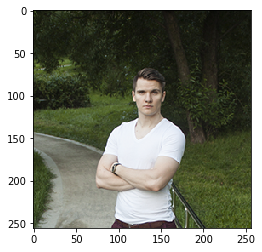

In [ ]:
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

### Загрузка и подготовка карты сегментации человек/фон

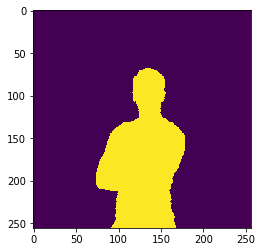

In [ ]:
gt = imageio.imread('me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[...,None]
_=plt.imshow(gt[...,0])

### Подготовка обучающего датасета
Наша цель создать пайплайн для обучения, включая данные, модель, лосс и т.д.

Поэтому для простоты возьмем очень простой датасет, состоящий из двух изображений: загруженная картинка и её зеркально отраженная копия.

При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить пайплайн, поэтому тестировать будем на том же, на чём и обучались

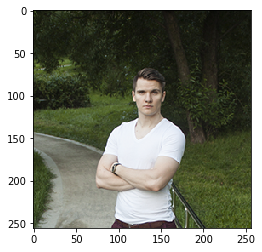

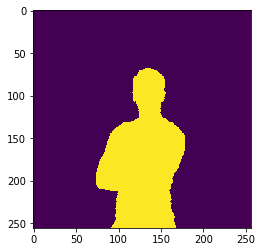

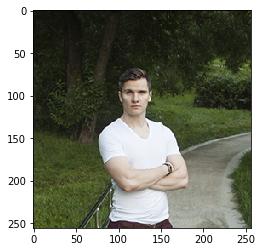

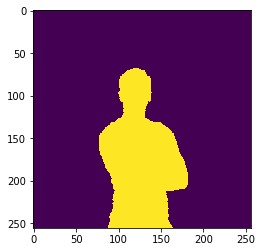

(<matplotlib.image.AxesImage at 0x26e63a21da0>, None)

In [ ]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

# Пайплайн обучения FCN

### Создание FCN модели
Модель создаётся путём наслелования от `tf.keras.Model`.

В методе `Model.__init__` создаются слои. 

В методе `Model.call` производится инференс с использованием созданных слоёв и других функций TensorFlow

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = Model()

### Параметры обучения

In [ ]:
NUM_EPOCHS = 100

### Подготовка модели к обучению
В качестве лосса используется бинарная кросс-энтропия (BinaryCrossentropy).
В лоссе автоматически происходит суммирование по всем измерениям.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

### Обучение модели

In [ ]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)

W0812 16:33:02.595728  4388 deprecation.py:323] From C:\Users\LK\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
2/2 [==============================] - 2s 990ms/sample - loss: 0.6849
Epoch 2/100
2/2 [==============================] - 0s 28ms/sample - loss: 0.6231
Epoch 3/100
2/2 [==============================] - 0s 27ms/sample - loss: 0.4640
Epoch 4/100
2/2 [==============================] - 0s 27ms/sample - loss: 0.2980
Epoch 5/100
2/2 [==============================] - 0s 28ms/sample - loss: 0.2241
Epoch 6/100
2/2 [==============================] - 0s 28ms/sample - loss: 0.2131
Epoch 7/100
2/2 [==============================] - 0s 27ms/sample - loss: 0.2175
Epoch 8/100
2/2 [==============================] - 0s 27ms/sample - loss: 0.2087
Epoch 9/100
2/2 [==============================] - 0s 27ms/sample - loss: 0.2101
Epoch 10/100
2/2 [==============================] - 0s 26ms/sample - loss: 0.2075
Epoch 11/100
2/2 [==============================] - 0s 26ms/sample - loss: 0.2012
Epoch 12/100
2/2 [==============================] - 0s 27ms/sample - loss: 0.1978
Epoch 13/100
2/2 [======

### График зависимости лосса от эпохи

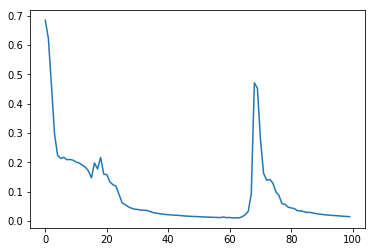

In [ ]:
plt.plot(history.history['loss'])

### Результат предсказания на входной картинке

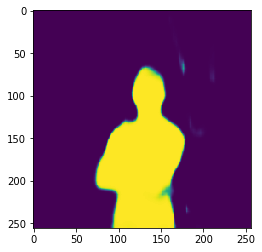

In [ ]:
out = model.predict(img[None, ...])
_=plt.imshow(out[0, ..., 0])

### Результат предсказания для всех картинок
По предсказанию сети получается карта сегментации с помощью порога.

Далее она отображается поверх исходной картинки.

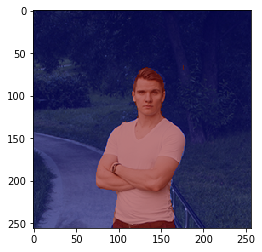

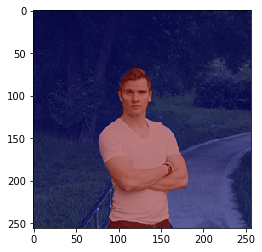

In [ ]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('jet')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()